In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as mplot
from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn import linear_model
import torch
import torch.nn as nn

In [30]:
sensor_df = pd.read_csv("sensor.csv")
print(sensor_df.head())
#Show column name
print(sensor_df.columns)

   Unnamed: 0            timestamp  sensor_00  sensor_01  sensor_02  \
0           0  2018-04-01 00:00:00   2.465394   47.09201    53.2118   
1           1  2018-04-01 00:01:00   2.465394   47.09201    53.2118   
2           2  2018-04-01 00:02:00   2.444734   47.35243    53.2118   
3           3  2018-04-01 00:03:00   2.460474   47.09201    53.1684   
4           4  2018-04-01 00:04:00   2.445718   47.13541    53.2118   

   sensor_03  sensor_04  sensor_05  sensor_06  sensor_07  ...  sensor_43  \
0  46.310760   634.3750   76.45975   13.41146   16.13136  ...   41.92708   
1  46.310760   634.3750   76.45975   13.41146   16.13136  ...   41.92708   
2  46.397570   638.8889   73.54598   13.32465   16.03733  ...   41.66666   
3  46.397568   628.1250   76.98898   13.31742   16.24711  ...   40.88541   
4  46.397568   636.4583   76.58897   13.35359   16.21094  ...   41.40625   

   sensor_44  sensor_45  sensor_46  sensor_47  sensor_48  sensor_49  \
0  39.641200   65.68287   50.92593  38.194440

In [31]:
#Remove unnamed column
sensor_df = sensor_df.loc[:, ~sensor_df.columns.str.contains('^Unnamed')]

#Backfill and forward fill data for missing values
sensor_df.loc[:, sensor_df.columns] =  sensor_df.loc[:, sensor_df.columns].ffill()
sensor_df.loc[:, sensor_df.columns] =  sensor_df.loc[:, sensor_df.columns].bfill()

#Update timestamp from string to datetime
sensor_df['timestamp'] = pd.to_datetime(sensor_df['timestamp'])

#Drop columns with no data
columns_no_data =  sensor_df.columns[sensor_df.isnull().any()].tolist()
sensor_df = sensor_df.drop(columns_no_data, axis=1)

In [32]:
#Normalize all sensor values
scaler = preprocessing.StandardScaler().set_output(transform="pandas")
scaled = scaler.fit_transform(sensor_df[sensor_df.columns[1:-1]])
sensor_df[sensor_df.columns[1:-1]] = scaled
sensor_df.head()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,0.314712,-0.152986,0.639354,1.057648,0.303460,0.177150,0.069552,0.200794,0.234873,...,-0.176765,-0.260475,1.759657,0.185929,-0.588581,0.086320,0.553107,-0.573679,-0.248495,NORMAL
1,2018-04-01 00:01:00,0.314712,-0.152986,0.639354,1.057648,0.303460,0.177150,0.069552,0.200794,0.234873,...,-0.176765,-0.260475,1.759657,0.185929,-0.588581,0.086320,0.553107,-0.573679,-0.248495,NORMAL
2,2018-04-01 00:02:00,0.279421,-0.074132,0.639354,1.093535,0.334797,0.008734,0.039638,0.170969,0.251998,...,-0.200346,-0.285471,1.737116,0.204429,-0.588581,0.061692,0.522877,-0.578096,-0.238382,NORMAL
3,2018-04-01 00:03:00,0.306308,-0.152986,0.627520,1.093534,0.260070,0.207740,0.037146,0.237509,0.278908,...,-0.271086,-0.310467,1.692034,0.204429,-0.588581,0.061692,0.507762,-0.580305,-0.240911,NORMAL
4,2018-04-01 00:04:00,0.281102,-0.139845,0.639354,1.093534,0.317923,0.184619,0.049610,0.226036,0.278908,...,-0.223925,-0.335463,1.714575,0.241429,-0.533159,0.089839,0.492648,-0.575888,-0.248495,NORMAL


2018-04-12T21:55:00.000000000
2018-04-18T00:30:00.000000000
2018-05-19T03:18:00.000000000
2018-05-25T00:30:00.000000000
2018-06-28T22:00:00.000000000
2018-07-08T00:11:00.000000000
2018-07-25T14:00:00.000000000


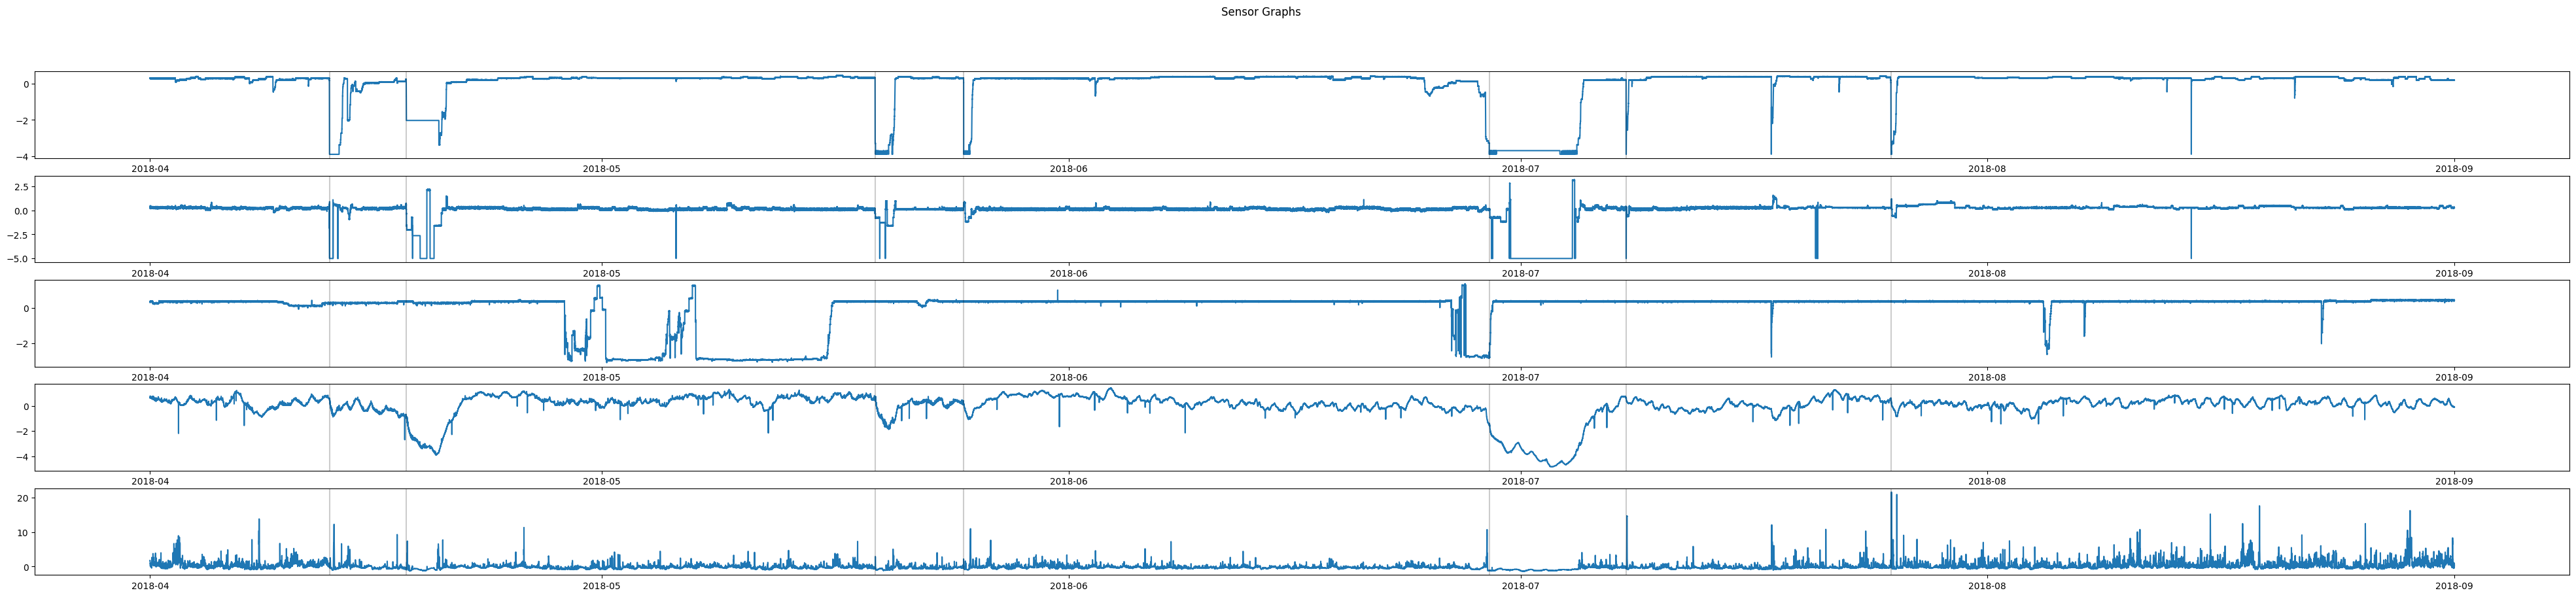

In [33]:
#Get timestamps of broken status
timestamps_to_highlight = sensor_df[sensor_df["machine_status"] == "BROKEN"]["timestamp"].to_numpy()

#Plot trend and mark broken timestamps
fig, (ax1, ax2, ax3, ax4, ax5) = mplot.subplots(5, figsize=(50, 10))
fig.suptitle('Sensor Graphs')


ax1.plot(sensor_df.timestamp, sensor_df.sensor_00)
ax2.plot(sensor_df.timestamp, sensor_df.sensor_08)
ax3.plot(sensor_df.timestamp, sensor_df.sensor_21)
ax4.plot(sensor_df.timestamp, sensor_df.sensor_02)
ax5.plot(sensor_df.timestamp, sensor_df.sensor_45)

for i in range(len(timestamps_to_highlight)):
    print(timestamps_to_highlight[i])
    ax1.axvline(pd.Timestamp(timestamps_to_highlight[i]), linestyle='solid', color='black', alpha=0.2)
    ax2.axvline(pd.Timestamp(timestamps_to_highlight[i]), linestyle='solid', color='black', alpha=0.2)
    ax3.axvline(pd.Timestamp(timestamps_to_highlight[i]), linestyle='solid', color='black', alpha=0.2)
    ax4.axvline(pd.Timestamp(timestamps_to_highlight[i]), linestyle='solid', color='black', alpha=0.2)
    ax5.axvline(pd.Timestamp(timestamps_to_highlight[i]), linestyle='solid', color='black', alpha=0.2)



2018-04-12T21:55:00.000000000
2018-04-18T00:30:00.000000000
2018-05-19T03:18:00.000000000
2018-05-25T00:30:00.000000000
2018-06-28T22:00:00.000000000
2018-07-08T00:11:00.000000000
2018-07-25T14:00:00.000000000


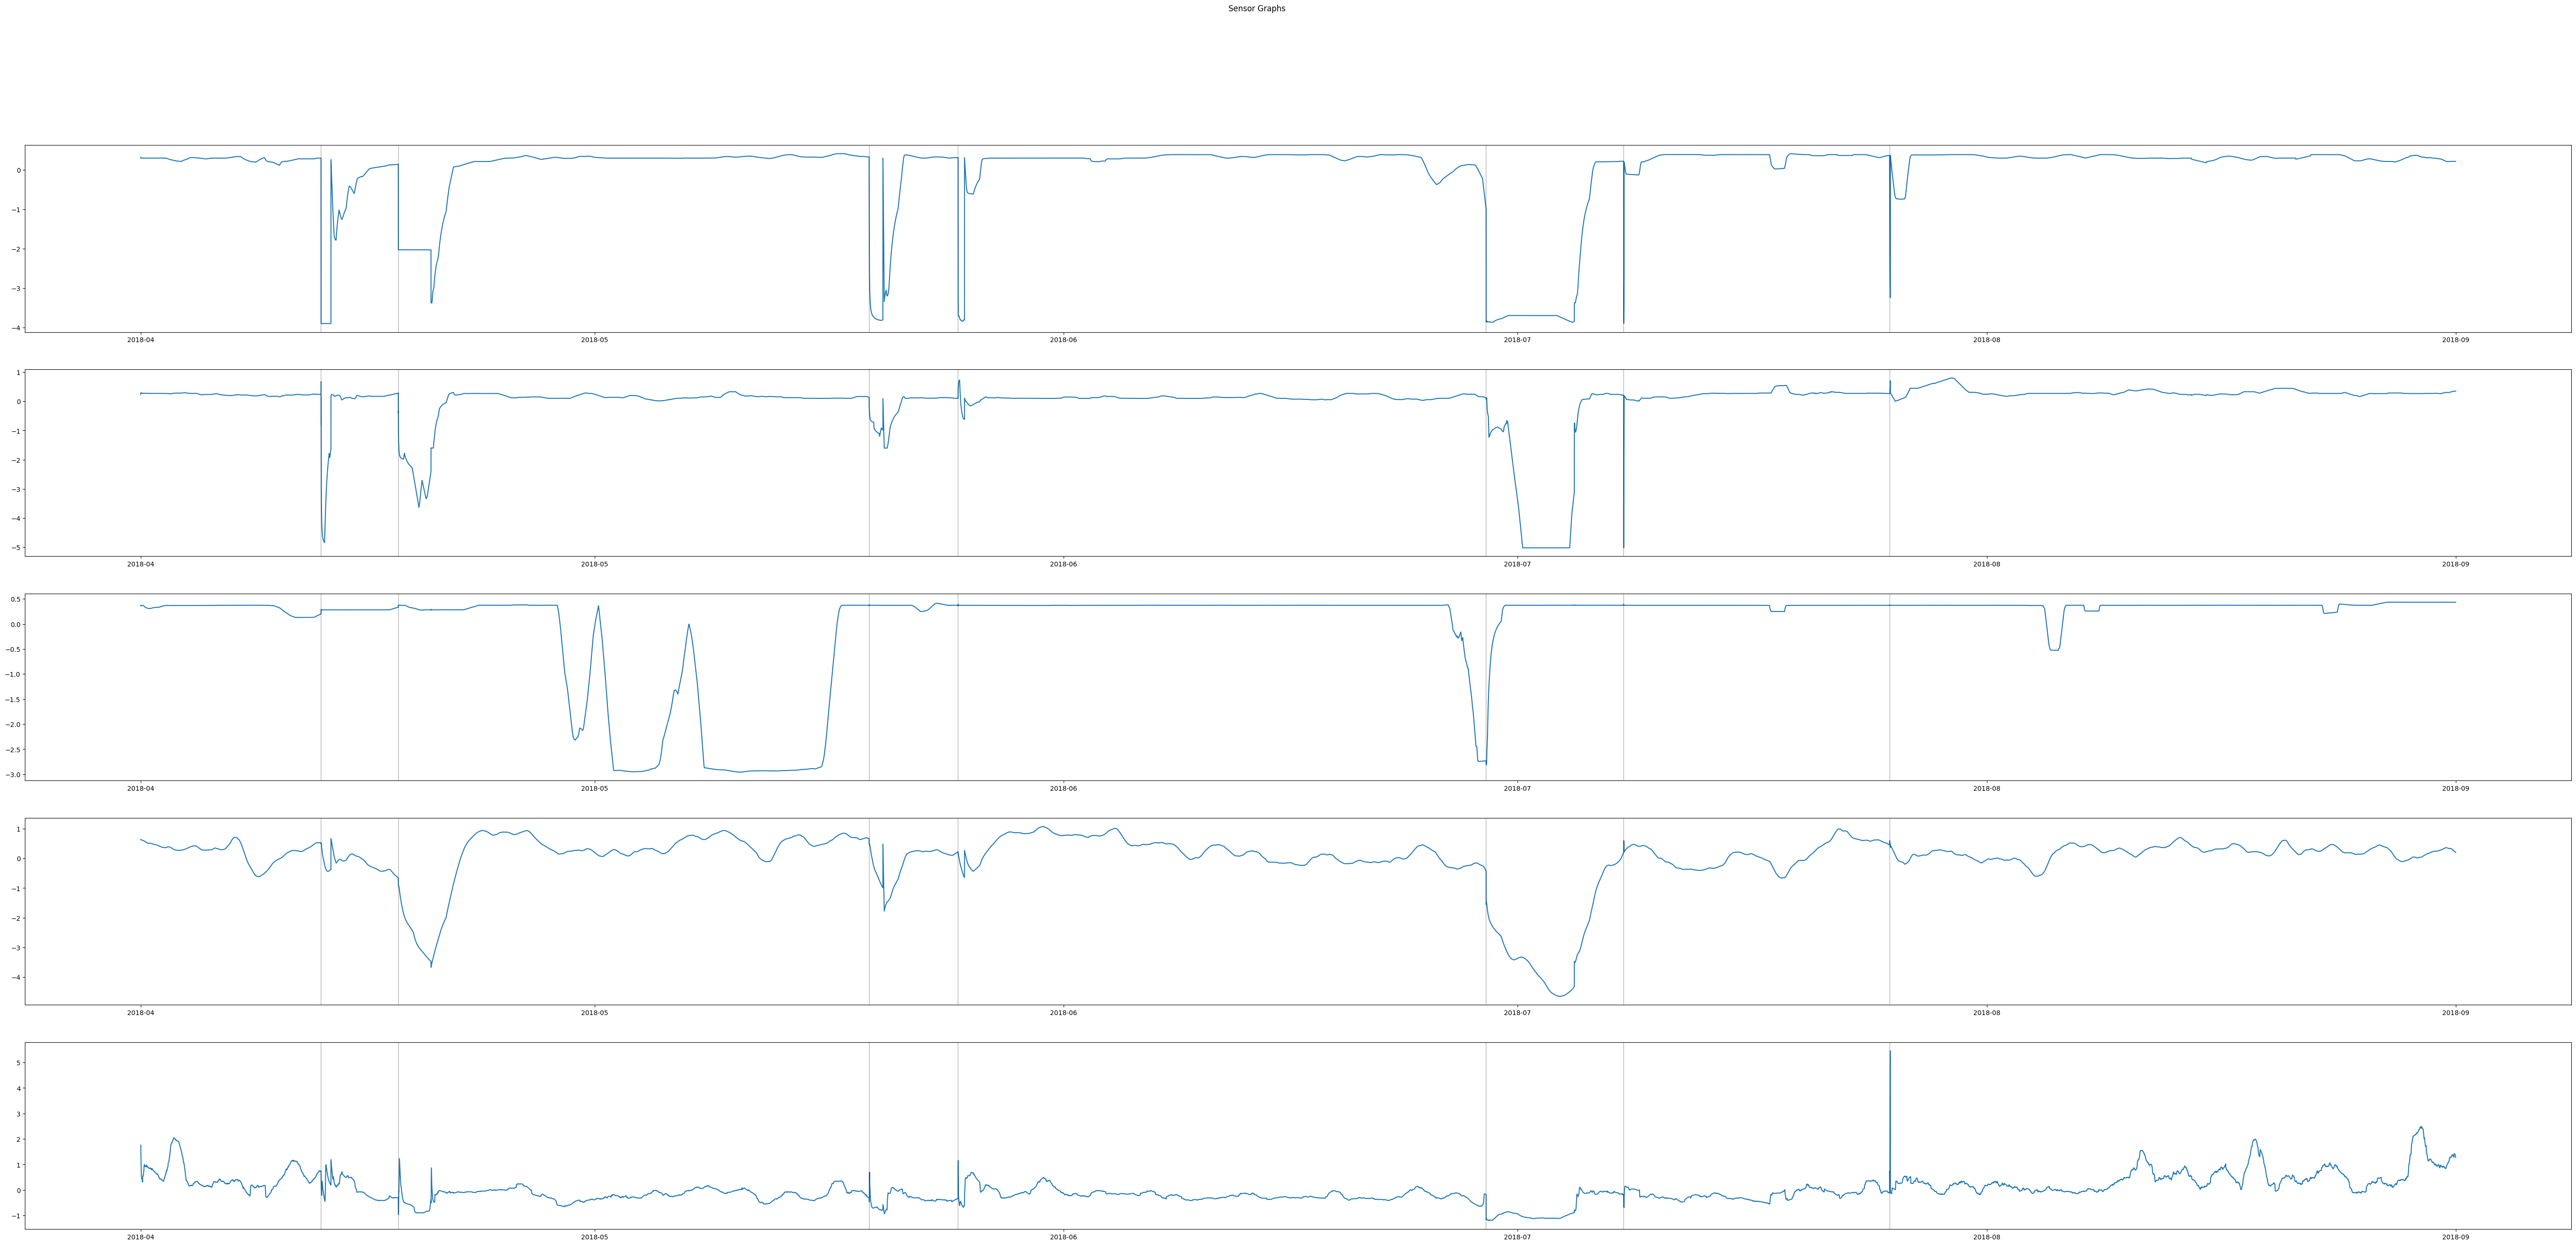

In [34]:
#Smoothen the data by calculating moving average of 1 day since granularity of sensor data is 1 min. Could try with 2 days of moving avg as well.
moving_df = sensor_df.set_index('timestamp').groupby(['machine_status']).rolling('1d').mean().reset_index()
moving_df = moving_df.sort_values(by='timestamp')
moving_good_df = moving_df[moving_df["machine_status"] != "BROKEN"][moving_df.columns[2:]]
moving_bad_df = moving_df[moving_df["machine_status"] == "BROKEN"][moving_df.columns[2:]]

fig, (ax1, ax2, ax3, ax4, ax5) = mplot.subplots(5, figsize=(70, 30))
fig.suptitle('Sensor Graphs')


ax1.plot(moving_df.timestamp, moving_df.sensor_00)
ax2.plot(moving_df.timestamp, moving_df.sensor_08)
ax3.plot(moving_df.timestamp, moving_df.sensor_21)
ax4.plot(moving_df.timestamp, moving_df.sensor_02)
ax5.plot(moving_df.timestamp, moving_df.sensor_45)

for i in range(len(timestamps_to_highlight)):
    print(timestamps_to_highlight[i])
    ax1.axvline(pd.Timestamp(timestamps_to_highlight[i]), linestyle='solid', color='black', alpha=0.2)
    ax2.axvline(pd.Timestamp(timestamps_to_highlight[i]), linestyle='solid', color='black', alpha=0.2)
    ax3.axvline(pd.Timestamp(timestamps_to_highlight[i]), linestyle='solid', color='black', alpha=0.2)
    ax4.axvline(pd.Timestamp(timestamps_to_highlight[i]), linestyle='solid', color='black', alpha=0.2)
    ax5.axvline(pd.Timestamp(timestamps_to_highlight[i]), linestyle='solid', color='black', alpha=0.2)

In [35]:
#Split data into good and bad. Good has sensor data with status NORMAL/RECOVERING where as bad has sensor data of BROKEN status
#Note this is for raw sensor values without moving average.
good_df = sensor_df[sensor_df["machine_status"] != "BROKEN"][sensor_df.columns[1:-1]]
bad_df = sensor_df[sensor_df["machine_status"] == "BROKEN"][sensor_df.columns[1:-1]]

#Implement Isolation Forest Algorithm
iso_algo = IsolationForest(contamination="auto", random_state=100)
predictions = iso_algo.fit(good_df).predict(good_df)
predictions = iso_algo.predict(bad_df)
print(predictions)
print(f"{classification_report([-1,-1,-1,-1,-1,-1,-1], predictions)}")

#F1 score is less than 0.7 which suggest this is not really good. Lets try it on data with moving average

[ 1  1  1 -1 -1 -1  1]
              precision    recall  f1-score   support

          -1       1.00      0.43      0.60         7
           1       0.00      0.00      0.00         0

    accuracy                           0.43         7
   macro avg       0.50      0.21      0.30         7
weighted avg       1.00      0.43      0.60         7



d:\Sensor ML Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Sensor ML Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Sensor ML Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [36]:
#Isolation Forest on moving average
iso_algo = IsolationForest(contamination="auto", random_state=51, max_features=50)
predictions = iso_algo.fit(moving_good_df).predict(moving_good_df)
predictions = iso_algo.predict(moving_bad_df)
print(predictions)
print(f"{classification_report([-1,-1,-1,-1,-1,-1,-1], predictions)}")

#F1 Score is 0.73 which is good and also better than using unsmoothened data.

[-1  1  1 -1 -1 -1  1]
              precision    recall  f1-score   support

          -1       1.00      0.57      0.73         7
           1       0.00      0.00      0.00         0

    accuracy                           0.57         7
   macro avg       0.50      0.29      0.36         7
weighted avg       1.00      0.57      0.73         7



d:\Sensor ML Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Sensor ML Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Sensor ML Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [37]:
#Use moving avg for kmeans
train = pd.concat([moving_good_df, moving_bad_df.head(5)],ignore_index=True)
test = moving_bad_df.tail(len(moving_bad_df)-2)
kmeans_algo = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(train)
kmeans_algo.predict(test)

array([0, 0, 1, 1, 0], dtype=int32)

In [38]:
#SGD One Class
svm_algo = linear_model.SGDOneClassSVM(random_state=40, nu=0.65, shuffle=True)
svm_algo.fit(train)
predictions = svm_algo.predict(test)
print(predictions)
print(f"{classification_report([-1,-1,-1,-1,-1], predictions)}")
#F1 Score is 0.75 which is good

[ 1 -1  1 -1 -1]
              precision    recall  f1-score   support

          -1       1.00      0.60      0.75         5
           1       0.00      0.00      0.00         0

    accuracy                           0.60         5
   macro avg       0.50      0.30      0.38         5
weighted avg       1.00      0.60      0.75         5



d:\Sensor ML Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Sensor ML Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Sensor ML Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:

def get_sequential(train_data, sequence_length):
    # Create sequences
    sequences = []
    target = []

    data = train_data[train_data.columns[2:]].to_numpy()
    category_data = train_data["machine_status"].to_numpy()

    for i in range(len(train_data) - sequence_length):
        sequences.append(data[i:i + sequence_length,])
        target.append(category_data[i + sequence_length,])
    
    x = np.array(sequences)
    y = np.array(target)
    return x, y


class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        print()
    
    def forward(self, x):
        print()


copied_data = moving_df.copy()
machine_status_dict = {"BROKEN":True, "NORMAL":False, "RECOVERING":False}
copied_data = copied_data.replace({"machine_status":machine_status_dict})

#Use until 3rd failure
train_data = copied_data[copied_data["timestamp"] <= timestamps_to_highlight[3]]
test_data = copied_data[copied_data["timestamp"] > timestamps_to_highlight[3]]


# Parameters
sequence_length = 60  # Define the sequence length (how many time steps to consider)

# Create sequences
sequences = []
target = []

#sensor_data = train_data[train_data.columns[2:]].to_numpy()


x_train, y_train = get_sequential(train_data, sequence_length)
x_test, y_test= get_sequential(test_data, sequence_length)

x_train_torch = torch.tensor(x_train[:, :, None], dtype=torch.float32)
y_train_torch = torch.tensor(y_train[:, None], dtype=torch.bool)

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

C:\Users\Abhilash\AppData\Local\Temp\ipykernel_23956\4266608367.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  copied_data = copied_data.replace({"machine_status":machine_status_dict})


Using cpu device
